---
title: 2.2 线性回归实现
date: 2024-2-3 14:00:00
tags: [机器学习,pytorch]
categories: [机器学习]
comment: true
toc: true
---
#  
<!--more-->
# 2. 线性回归实现


In [14]:
import random
import torch
from d2l import torch as d2l
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# 2.1 生成数据集
- 使用线性模型参数w = [2, −3.4]⊤、b = 4.2 和噪声项ϵ~N(0,0.01)生成数据集及其标签：

features: tensor([1.2604, 0.9351]) 
label: tensor([3.5493])


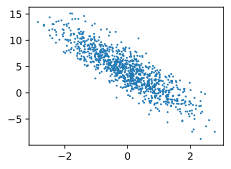

In [15]:
#1 生成数据集
def synthetic_data(w,b,num_examples): #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0,1,(num_examples,len(w))) #生成服从正态分布的数据
    y = torch.matmul(X,w) + b #矩阵乘法
    y += torch.normal(0,0.01,y.shape) #加上噪声
    return X,y.reshape((-1,1))
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print('features:',features[0],'\nlabel:',labels[0])

#2 可以看到x1与y是线性关系
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)


## 2.2 读取数据集
- 定义一个函数打乱样本并返回批量数据：
    - 输入：批量大小、特征、标签
    - 输出：批量数据

In [16]:
def data_iter(batch_size,features,labels):
    num_examples = len(features) #1 样本数
    indices = list(range(num_examples)) #2 生成下标
    random.shuffle(indices) #3 打乱下标
    for i in range(0,num_examples,batch_size): #4 遍历数据集，每次取出batch_size个样本
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices],labels[batch_indices] #5 可迭代对象，每次返回batch_size个样本

batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,'\n',y)
    break

tensor([[ 0.1474, -0.8037],
        [ 0.3242,  0.3905],
        [-0.1883,  0.1497],
        [ 0.4741,  0.2937],
        [ 1.6234, -0.3555],
        [ 1.2714, -1.5737],
        [-0.6498,  1.9078],
        [ 0.6298,  0.4764],
        [ 0.2344, -1.3566],
        [-0.4173, -0.4298]]) 
 tensor([[ 7.2271],
        [ 3.5186],
        [ 3.3331],
        [ 4.1500],
        [ 8.6549],
        [12.0805],
        [-3.5749],
        [ 3.8355],
        [ 9.2662],
        [ 4.8142]])


## 2.3 初始化模型参数
- 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。


In [17]:
w = torch.normal(0,0.01,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

## 2.4 定义模型


In [18]:
def linreg(X,w,b): #@save
    """线性回归模型。"""
    return torch.matmul(X,w) + b

## 2.5 定义损失函数
- 平方损失函数

In [19]:
def squred_loss(y_hat,y): #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

## 2.6 定义优化算法


In [20]:
def sge(params,lr,batch_size): #@save
    """小批量随机梯度下降。"""
    with torch.no_grad(): #在该模块下，所有计算得出的tensor的requires_grad都自动设置为False ???
        for param in params:
            param -= lr*param.grad/batch_size #这是一个计算操作，会产生新的梯度信息，所以需要关闭梯度信息 ???
            param.grad.zero_() #将param.grad清零

## 2.7 训练
- 初始化参数
- 重复以下训练，知道完成：
    - 计算梯度$g \leftarrow \partial_{(\mathbf{w},b)}\frac{1}{|\mathcal{B}|}\sum_{i\in\mathcal{B}}l(x^{(i)},y^{(i)},\mathbf{w},b)$
    - 更新参数$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \eta g$

In [21]:
#1 超参数
lr = 0.03
num_epochs = 3
net = linreg
loss = squred_loss

#2 训练
for epoch in range(num_epochs):
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) #l是有关小批量X和y的损失
        l.sum().backward() #小批量的损失对模型参数求梯度,因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        sge([w,b],lr,batch_size) #使用小批量随机梯度下降迭代模型参数
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

#3 检验
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

epoch 1,loss 0.030588
epoch 2,loss 0.000105
epoch 3,loss 0.000049
w的估计误差：tensor([ 0.0010, -0.0008], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0008], grad_fn=<RsubBackward1>)
